In [1]:
from Selfish_RNN.sparse_rnn_core import Masking, CosineDecay
from randman_data import get_data_loaders
from LIFlayer import NHiddenModel
import torch


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


In [4]:
#data generation vars 
nb_classes = 4
nb_units = 100
nb_steps = 100
nb_samples = 1000
batch_size = 100

dataloader_train, dataloader_test = get_data_loaders(nb_classes,nb_units,nb_steps,nb_samples,batch_size)

#model vars
num_hidden_layers = 1
hidden_size = 100
in_size = nb_units
out_size = nb_classes

#training vars
epochs=20

#masking vars
death_rate = 1
decay_steps = len(dataloader_train) * epochs
density = .9



In [5]:
model = NHiddenModel(num_hidden_layers,in_size,hidden_size,out_size,with_recurrent=False).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
mask = None
cos_decay = CosineDecay(death_rate,decay_steps)
mask = Masking(optimizer,death_rate_decay=cos_decay,death_rate=1)
mask.add_module(model,density)
mask.init(density=density)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

/Users/kerstjens/msc_thesis/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


0.7125444337725639


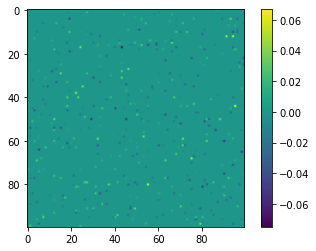

0.698957446962595


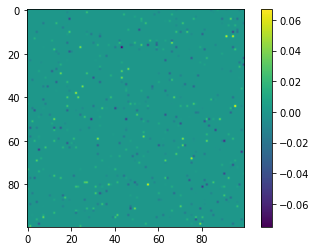

0.7183785326778889


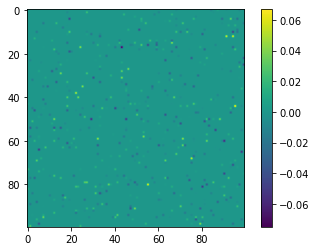

0.6975893154740334


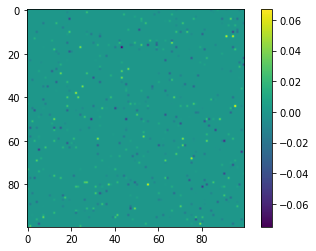

0.7302064821124077


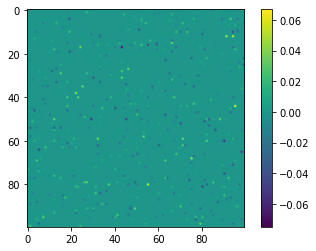

0.6930068321526051


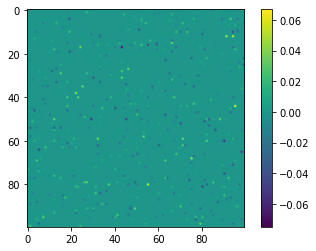

0.7070426344871521


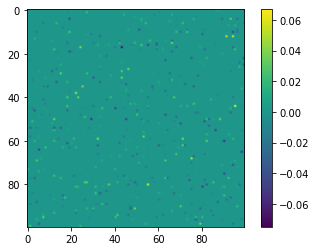

0.7169671803712845


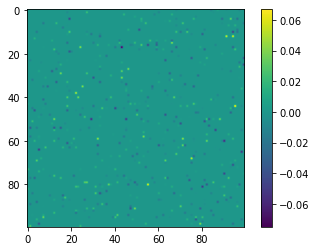

0.726539857685566


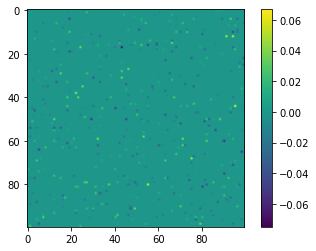

KeyboardInterrupt: 

In [46]:
ce_loss = torch.nn.CrossEntropyLoss()
decay = .99

for e in range(epochs):
    mean_loss = []
    for x,label in dataloader_train:
        model.init_states()
        Sprobe = torch.zeros((dataloader_train.batch_size,model.out_channels),device=device)
        x = x.to(device)
        label=label.to(device)
        optimizer.zero_grad()
        for n in range(nb_steps):
            out_state = model(x[:,n])
            Sprobe = decay * Sprobe + out_state.S
        
        prediction = Sprobe
        accuracy = (label == prediction.argmax(axis=1)).sum()/len(prediction)
        loss = ce_loss(prediction,label)
        mean_loss.append(loss.item())
        loss.backward()
        if mask is not None: mask.step()
        else: optimizer.step()

    
    mean_loss = sum(mean_loss)/len(dataloader_train)
    print(mean_loss)
    plt.imshow(model.layers[0].fc_layer.weight.data.cpu())
    plt.colorbar()
    plt.show()

            

In [30]:
loss.item()

4.499911785125732

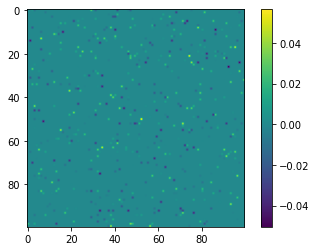

In [40]:
import matplotlib.pyplot as plt

plt.imshow(model.layers[0].fc_layer.weight.data.cpu())
plt.colorbar()

tensor(0., device='cuda:0')